# Assignment 2.1: Feed-Forward Neural Network
Student Name 1: Mateusz Klimas

Student Name 2: Juan Luis Ruiz-Tagle Oriol

Student Name 3: Jorge Martín Lasaosa

## German Traffic Sign Benchmark

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01" -O FullIJCNN2013.zip && rm -rf /tmp/cookies.txt
!unzip FullIJCNN2013.zip

--2020-02-26 10:52:20--  https://docs.google.com/uc?export=download&confirm=&id=1De6T4b6mtFQALtuyT05zxGkS1YHKXG01
Resolving docs.google.com (docs.google.com)... 74.125.140.113, 74.125.140.100, 74.125.140.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.140.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip       [ <=>                ]   3.03K  --.-KB/s    in 0s      

2020-02-26 10:52:20 (31.0 MB/s) - ‘FullIJCNN2013.zip’ saved [3103]

Archive:  FullIJCNN2013.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of FullIJCNN2013.zip or
        FullIJCNN2013.zip.zip, and cannot find FullIJCNN2013.zip.ZIP, period.


In [100]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [101]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

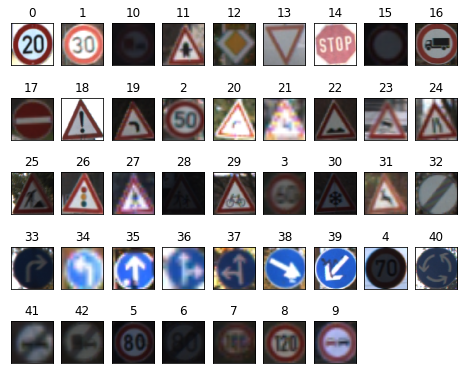

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
!pip install keras
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

# Normalize the images to be values in range [0, 1]
tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [5]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.regularizers import l2

In [ ]:
kernel_regularizer=keras.regularizers.l2(0.001)
model.add(Dense(250, kernel_initializer='he_normal', kernel_regularizer='l2'))


In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
model.add(Dense(250, kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dense(250, kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy' ])
model.summary()

# Results after tuning parameters

### 100 epochs    2 layers
- ffNN took 0.2871842384338379 seconds
- Test loss: 0.777482806315 - Accuracy: 0.831024930913

### 80 epochs
- ffNN took 0.2552049160003662 seconds
- Test loss: 0.947215808726 - Accuracy: 0.819944598503

### 80 epochs + BatchNormalization before act-function
- ffNN took 0.20645499229431152 seconds
- Test loss: 0.673862372244 - Accuracy: 0.828254848141

### 80 epochs + BatchNormalization after act-function + elu (BEST MODEL)
- ffNN took 0.2287149429321289 seconds
- Test loss: 0.59520227427 - Accuracy: 0.889196676065

### 80 epochs + BatchNormalization after act-function + relu

- ffNN took 0.19974017143249512 seconds
- Test loss: 1.71621843784 - Accuracy: 0.493074792264

### 80 epochs + BatchNormalization after act-function + leakyrelu alpha = 0.3

- ffNN took 0.2029409408569336 seconds
- Test loss: 0.733232077469 - Accuracy: 0.808864266423

### 80 epochs + BatchNormalization after act-function + leakyrelu alpha = 0.1

- ffNN took 0.2630026340484619 seconds
- Test loss: 0.678641441951 - Accuracy: 0.822714681936

In [ ]:
data = model.fit(tr_signs, tr_labels, batch_size=16, epochs=80, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])
start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))


# CIFAR 100 Dataset

In [64]:
from keras.datasets import cifar100
(_x_train, _y_train), (_x_test, _y_test) = cifar100.load_data(label_mode='fine')


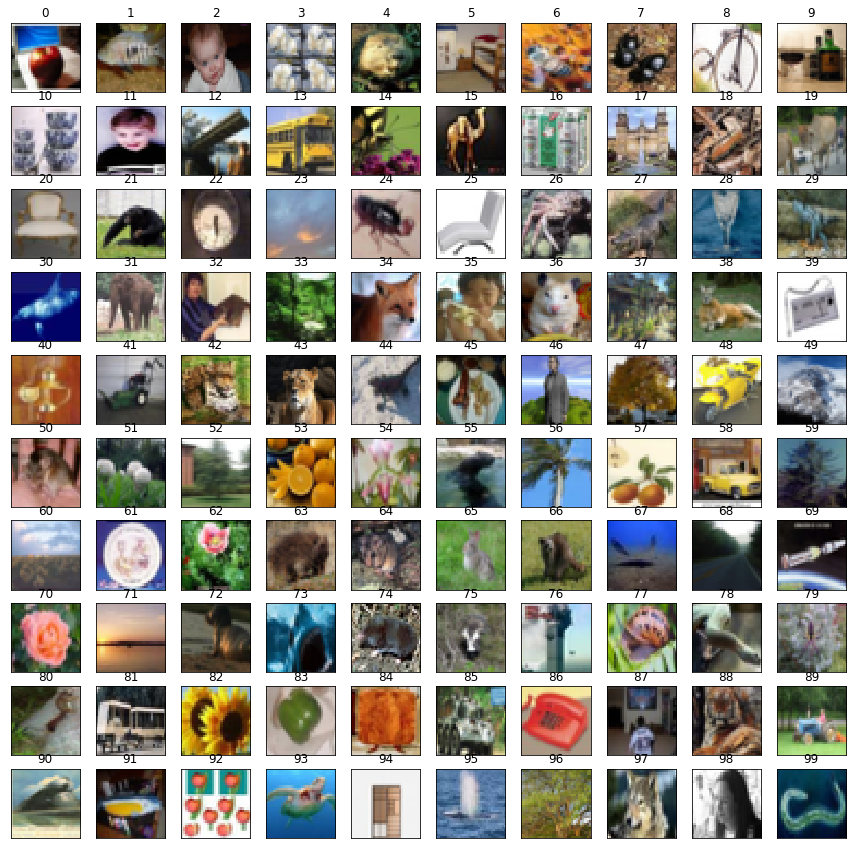

In [65]:
# Show examples from each class
class_names = np.unique(_y_train)
num_classes = len(class_names)

fig, axes = plt.subplots(10, 10,figsize=(15,15))
for i in range(num_classes):
    ax = axes.flatten()[i]
    indices = np.where(np.isin(_y_train, class_names[i]))[0]
    ax.imshow(_x_train[int(np.random.choice(indices, 1))])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(i)
plt.show()

In [69]:
# Data pre-processing
x_val = _x_train[40000:]
y_val = _y_train[40000:]
x_train = _x_train[:40000]
y_train = _y_train[:40000]
x_test = _x_test
y_test = _y_test

# Normalize the images to be values in range [0, 1]
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

from keras.utils import np_utils
# Converts a class vector (integers) to binary class matrix
tr_labels = np_utils.to_categorical(y_train, num_classes)
va_labels = np_utils.to_categorical(y_val, num_classes)
te_labels = np_utils.to_categorical(y_test, num_classes)

CIFAR_SIZE = (32, 32)

In [47]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers

model_cifar = Sequential()
model_cifar.add(Flatten(input_shape=(CIFAR_SIZE[0], CIFAR_SIZE[1], 3)))
model_cifar.add(Dense(250, kernel_initializer='he_normal'))
model_cifar.add(Dropout(0.2))
model_cifar.add(Activation('elu'))
model_cifar.add(BatchNormalization())
model_cifar.add(Dense(250, kernel_initializer='he_normal'))
model_cifar.add(Dropout(0.2))
model_cifar.add(Activation('elu'))
model_cifar.add(BatchNormalization())
model_cifar.add(Dense(num_classes))
model_cifar.add(Activation('softmax'))

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_cifar.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy' ])
model_cifar.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_61 (Dense)             (None, 250)               768250    
_________________________________________________________________
dropout_39 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_57 (Activation)   (None, 250)               0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 250)               1000      
_________________________________________________________________
dense_62 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_40 (Dropout)         (None, 250)               0         
__________

In [71]:
data_cifar = model_cifar.fit(x_train, tr_labels, batch_size=16, epochs=80, verbose=2, validation_data=(x_val, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = model_cifar.evaluate(x_test, te_labels, verbose=0)
end = time()
print('ffNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 40000 samples, validate on 10000 samples
Epoch 1/80
 - 20s - loss: 4.3509 - acc: 0.0648 - val_loss: 3.8403 - val_acc: 0.1290
Epoch 2/80
 - 20s - loss: 3.9333 - acc: 0.1109 - val_loss: 3.6781 - val_acc: 0.1578
Epoch 3/80
 - 20s - loss: 3.7826 - acc: 0.1347 - val_loss: 3.5658 - val_acc: 0.1727
Epoch 4/80
 - 20s - loss: 3.6981 - acc: 0.1462 - val_loss: 3.5269 - val_acc: 0.1849
Epoch 5/80
 - 20s - loss: 3.6311 - acc: 0.1580 - val_loss: 3.5197 - val_acc: 0.1765
Epoch 6/80
 - 20s - loss: 3.5754 - acc: 0.1662 - val_loss: 3.4697 - val_acc: 0.1935
Epoch 7/80
 - 20s - loss: 3.5320 - acc: 0.1738 - val_loss: 3.4309 - val_acc: 0.1966
Epoch 8/80
 - 20s - loss: 3.4888 - acc: 0.1824 - val_loss: 3.3995 - val_acc: 0.2044
Epoch 9/80
 - 20s - loss: 3.4549 - acc: 0.1883 - val_loss: 3.3820 - val_acc: 0.2045
Epoch 10/80
 - 20s - loss: 3.4211 - acc: 0.1944 - val_loss: 3.4060 - val_acc: 0.2012
Epoch 11/80
 - 20s - loss: 3.3947 - acc: 0.1957 - val_loss: 3.3475 - val_acc: 0.2143
Epoch 12/80
 - 20s - los

## ELU Validation accuracy across epochs

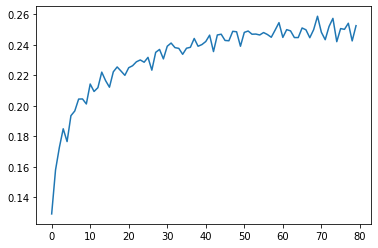

In [73]:
plt.plot(data_cifar.history['val_acc'])

## Grid search with activation functions

In [84]:
names = ["  elu", " relu", " tanh", "lrelu"]
print("Activation", "Accuracy", "Loss")
for r, n in zip(results, names):
    print(n,": ", r[2], r[1])
    

Activation Accuracy Loss
  elu :  0.2563 3.19958763504
 relu :  0.1848 3.52705967712
 tanh :  0.2433 3.31554829063
lrelu :  0.2264 3.29659153976


In [77]:
results = []
results.append(["elu", 3.19958763504, 0.2563, data_cifar])

In [ ]:
epochs = 50
functions = [Activation('relu'), Activation('tanh'), LeakyReLU()]
#results = []
for f in functions:
    m = create_model(f)
    data = m.fit(x_train, tr_labels, batch_size=16, epochs=epochs, verbose=2, validation_data=(x_val, va_labels), callbacks=[tensorboard])
    loss, acc = m.evaluate(x_test, te_labels, verbose=0)
    results.append([f,loss,acc, data])


Train on 40000 samples, validate on 10000 samples
Epoch 1/50
 - 21s - loss: 4.5376 - acc: 0.0431 - val_loss: 4.0604 - val_acc: 0.0831
Epoch 2/50
 - 20s - loss: 4.1950 - acc: 0.0665 - val_loss: 3.9005 - val_acc: 0.1119
Epoch 3/50
 - 20s - loss: 4.0996 - acc: 0.0751 - val_loss: 3.8069 - val_acc: 0.1274
Epoch 4/50
 - 20s - loss: 4.0198 - acc: 0.0886 - val_loss: 3.7850 - val_acc: 0.1300
Epoch 5/50
 - 20s - loss: 3.9564 - acc: 0.0959 - val_loss: 3.7492 - val_acc: 0.1409
Epoch 6/50
 - 20s - loss: 3.9467 - acc: 0.0957 - val_loss: 3.7275 - val_acc: 0.1406
Epoch 7/50
 - 20s - loss: 3.9021 - acc: 0.1025 - val_loss: 3.7371 - val_acc: 0.1412
Epoch 8/50
 - 20s - loss: 3.8565 - acc: 0.1050 - val_loss: 3.6735 - val_acc: 0.1533
Epoch 9/50
 - 20s - loss: 3.8662 - acc: 0.1080 - val_loss: 3.6826 - val_acc: 0.1493
Epoch 10/50
 - 20s - loss: 3.8844 - acc: 0.1035 - val_loss: 3.6730 - val_acc: 0.1500
Epoch 11/50
 - 20s - loss: 3.8496 - acc: 0.1117 - val_loss: 3.6250 - val_acc: 0.1607
Epoch 12/50
 - 20s - los

In [72]:
def create_model(function):
    initializer = 'he_normal' if function == Activation('tanh') else 'glorot_uniform'
    model_cifar = Sequential()
    model_cifar.add(Flatten(input_shape=(CIFAR_SIZE[0], CIFAR_SIZE[1], 3)))
    model_cifar.add(Dense(250, kernel_initializer= initializer))
    model_cifar.add(Dropout(0.2))
    model_cifar.add(function)
    model_cifar.add(BatchNormalization())
    model_cifar.add(Dense(250, kernel_initializer='he_normal'))
    model_cifar.add(Dropout(0.2))
    model_cifar.add(function)
    model_cifar.add(BatchNormalization())
    model_cifar.add(Dense(num_classes))
    model_cifar.add(Activation('softmax'))
    opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model_cifar.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy' ])
    #model_cifar.summary()
    return model_cifar